<div style="background-color:#035FCA; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 1px solid #19180F; border-radius:10px"> Pegasus </div>

<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">🔧 Architecture Overview⚙️
 </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">

- Input Text: Pegasus receives the original text that needs to be condensed as its input.<br>
    
- Encoder: The encoder component is in charge of analyzing the input text and extracting useful representations. It is made up of the following components:.
    
- Input: The encoder is fed the original text as input.<br>
    
- Embedding: An embedding layer is used to convert the input tokens into continuous vector representations. In this step, the tokens' semantic meaning is captured.<br>
    
- Transformer Layers: Various transformer layers are used to pass the embedded tokens through. Self-attention mechanisms and neural networks that feed forward are used in each transformer layer. With the help of self-attention, the model is able to concentrate on crucial elements of the input and accurately represent the contextual relationships between words.<br>
    
- Encoded Representation: The encoder's output is the text's encoded representation.
It captures the crucial details and takes into account the input's context.<br>
<br>
    
- Decoder: The component of the decoder uses the encoded representation to produce the abstractive summary. The components are <br>
    
- Input: The decoding operation begins with a starting token (e. g. the input to the decoder (i.e., a unique "start" token).<br>
    
- Embedding: Using an embedding layer, the input token is converted into a continuous vector representation.<br>
    
- Transformer Layers: The decoder has several transformer layers, just like the encoder. In order to record the connections between the generated summary tokens, these layers make use of feed-forward networks and self-attention mechanisms. Self-attention aids the model's comprehension of the context and interdependencies between the summary tokens created thus far.<br>
    
- Linear Layer: The hidden representation is projected to the vocabulary size as the output of the transformer layers passes through a linear layer.<br>
    
- Softmax: The softmax activation function is applied to the output of the linear layer to generate a probability distribution over the vocabulary for each summary token.<br>
    
- The decoder creates summary tokens by randomly selecting from the probability distribution obtained from the softmax. The procedure keeps going until either an "end" token is produced or the predetermined maximum length is reached. The generated summary tokens serve as an abstractive summary of the input text.<br>

- Connections: Through attention connections, the encoder connects the decoder to the encoded representation as a source of data. This attention mechanism enables the decoder to concentrate while generating each summary token on pertinent areas of the encoded representation. Between the decoder's own output and its input, there is also an attention connection. This enables the decoder to take care of its previous outputs and make sure the generated summary is coherent and consistent.<br>

Overall, Pegasus uses the encoder-decoder framework, self-attention mechanisms, and transformer architecture to efficiently extract the crucial information from the input text and produce coherent abstractive summaries. Pegasus can create summaries that go beyond straightforward extractive techniques and produce informative and meaningful summaries thanks to the attention connections and contextual awareness provided by the transformer layers. <br></div> 
<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px"> 🏢 Architecture Diagram.
 </div>

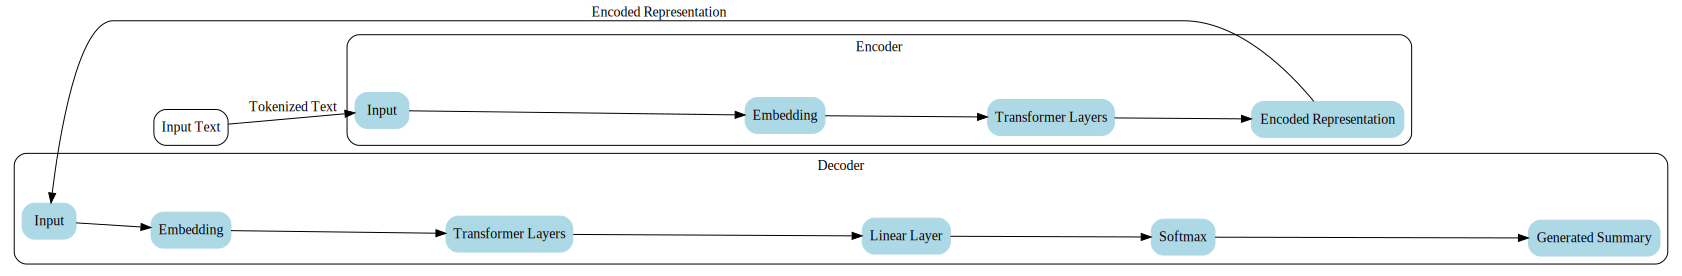

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/pegasus.svg'
display(SVG(filename=svg_file))

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Importing modules </div>

In [2]:
!pip install rouge --quiet

In [3]:
import pandas as pd
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from rouge import Rouge


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining custom dataset class </div>

In [4]:
class SummarizationDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=512, max_output_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        article = self.data.iloc[index]["article"]
        summary = self.data.iloc[index]["highlights"]
        input_ids = self.tokenizer.encode(article, max_length=self.max_input_length, truncation=True, padding="max_length")
        output_ids = self.tokenizer.encode(summary, max_length=self.max_output_length, truncation=True, padding="max_length")
        return {"input_ids": input_ids, "attention_mask": [int(token_id != 0) for token_id in input_ids], "decoder_input_ids": output_ids[:-1], "decoder_attention_mask": [1] * (len(output_ids) - 1), "labels": output_ids[1:]}


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Loading the dataset </div>

In [5]:
train_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
test_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv")
val_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv")


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Loading the pegasus tokenizer and model </div>

In [6]:
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining the training and validation datasets </div>

In [7]:
train_dataset = SummarizationDataset(train_df, tokenizer)
val_dataset = SummarizationDataset(val_df, tokenizer)

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining collate function </div>

In [8]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    decoder_input_ids = [item["decoder_input_ids"] for item in batch]
    decoder_attention_mask = [item["decoder_attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]
    max_input_length = max(len(ids) for ids in input_ids)
    max_output_length = max(len(ids) for ids in decoder_input_ids)
    input_ids = [ids + [0] * (max_input_length - len(ids)) for ids in input_ids]
    attention_mask = [mask + [0] * (max_input_length - len(mask)) for mask in attention_mask]
    decoder_input_ids = [ids + [0] * (max_output_length - len(ids)) for ids in decoder_input_ids]
    decoder_attention_mask = [mask + [0] * (max_output_length - len(mask)) for mask in decoder_attention_mask]
    labels = [ids + [-100] * (max_output_length - len(ids)) for ids in labels]
    return {"input_ids": torch.tensor(input_ids), "attention_mask": torch.tensor(attention_mask), "decoder_input_ids": torch.tensor(decoder_input_ids), "decoder_attention_mask": torch.tensor(decoder_attention_mask), "labels": torch.tensor(labels)}


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining the train and val dataloaders </div>

In [9]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2,collate_fn=collate_fn)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining the optimizer and learning rate scheduler </div>

In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=10000)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Guaging the steps per epoch as per the batch size </div>

In [11]:
len(train_loader),len(val_loader)

(143557, 6684)

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Fine tuning the model </div>

In [12]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
for epoch in range(10):
    train_loss = 0
    for step,batch in tqdm(enumerate(train_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if step%100==0 and step>0:
            print("Step-{},Train Loss-{}".format(step,loss.item()))
            break#intentionally breaking the training after 100 steps since it's going to take long to train,feel free to comment and train more
        train_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            val_loss += loss.item()
            if step%100==0 and step>0:
                print("Step-{},Val Loss-{}".format(step,loss.item()))
                break #intentionally breaking the training after 100 steps since it's going to take long to validate,feel free to comment and validate more
        val_loss /= len(val_loader)
    model.train()
    break # when you train more then uncomment this, too !
    print(f"Epoch {epoch+1} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")


100it [00:50,  1.97it/s]


Step-100,Train Loss-10.456241607666016


100it [00:15,  6.58it/s]

Step-100,Val Loss-8.677318572998047


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Intentionally breaking the training after 100 steps since it's going to take time to train ! Feel free to uncomment relevant lines to train more ! </div>

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Saving the fine tuned model </div>

In [13]:
model.save_pretrained("fine_tuned_pegasus")
tokenizer.save_pretrained("fine_tuned_pegasus")


('fine_tuned_pegasus/tokenizer_config.json',
 'fine_tuned_pegasus/special_tokens_map.json',
 'fine_tuned_pegasus/spiece.model',
 'fine_tuned_pegasus/added_tokens.json')

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Loading the fine tuned model and tokenizer </div>

In [14]:
model = PegasusForConditionalGeneration.from_pretrained("fine_tuned_pegasus")
tokenizer = PegasusTokenizer.from_pretrained("fine_tuned_pegasus")


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining the test dataset </div>

In [15]:
test_dataset = SummarizationDataset(test_df, tokenizer)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Defining the test dataloader </div>

In [16]:
test_loader = DataLoader(test_dataset, batch_size=1,collate_fn=collate_fn)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Generating predictions on the test dataset </div>

In [17]:
len(test_loader)

11490

In [18]:
model.to(device)
model.eval()
predictions = []
with torch.no_grad():
    for step, batch in tqdm(enumerate(test_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_ids = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], max_length=128, decoder_start_token_id=tokenizer.pad_token_id)
        batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]
        predictions.extend(batch_predictions)
        if step==100:
            break # breaking after generating 100 predictions.. since it's going to take long to predict on entire set


100it [03:53,  2.34s/it]


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Comment break to generate predictions on entire set and also the slicing in the test_df below </div>

In [19]:
len(predictions)

101

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Writing predicted summary to a new test set </div>

In [20]:
# Save the predictions to a CSV file
test_df = test_df[:101]# for 100 predicitons only
print(len(test_df))
test_df["predictions"] = predictions
test_df.to_csv("test_predictions.csv", index=False)

101


/tmp/ipykernel_1647/959527322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = predictions


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Checking the generated summaries. </div>

In [21]:
test_df

,id,article,highlights,predictions
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,"While United Airlines has 30 inches of space, ..."
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,"Next level drunk: Intoxicated Rahul Kumar, 17,..."
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,Freedman has stabilised Forest since he replac...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,Liverpool target Neto is also wanted by PSG an...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...","Speaking out: Bruce Jenner, pictured on 'Keepi..."
...,...,...,...,...
96,5cf4682cd03238d5867027ce9492b626cd1ed011,"Jameela spent £3,000 on having all her amalgam...","Jameela Jamil, 29, is convinced dental work tr...","Jameela spent £3,000 on having all her amalgam..."
97,3815d19af18ff22be6ad6095722d7367bb7271af,A paramedic who pretended he was gay to get cl...,"Christopher Bridger, 25, attacked three women ...","Christopher Bridger, 25, who was jailed for 12..."
98,fb207604ffa7e8371c622840445825db8993d4d2,"Paris Saint-Germain face Nice on Saturday, hop...",Paris Saint-Germain captain Thiago Silva suffe...,"Paris Saint-Germain face Nice on Saturday, hop..."
99,d25d52c434a13c1df5faa593e8a097d2f501a2b6,"(CNN)You know the phrase ""dodging a bullet""? F...",.50-caliber bullets equipped with optical sens...,"In February, the ""smart bullets"" --.50-caliber..."


<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px"> Introduction to ROUGE </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to assess the value of automatic summaries or machine-generated text by contrasting them with reference summaries created by humans. In terms of shared n-grams, or the length of consecutive words or characters, ROUGE calculates the overlap between the generated summary and the reference summaries.<br>
<br>
These are the three ROUGE variations that are most frequently used.<br>
- ROUGE-1, also referred to as unigram ROUGE, calculates the amount of overlap between the reference summaries and the summaries that were generated.
Based on the shared unigrams, it computes accuracy, recall, and F1-score.<br>
- ROUGE-2, also referred to as bigram ROUGE, measures how much the generated summary and the reference summaries overlap in terms of consecutive word pairs. It takes into account the F1-score, recall, and precision of shared bigrams.<br>
- ROUGE-L: The LCS between the reference summaries and the generated summaries is the main focus of the ROUGE-L metric. The shared LCS, which stands for the longest word sequence that appears in both the generated summary and the reference summaries, is the basis for computing precision, recall, and F1-score. Longer summaries can be evaluated using ROUGE-L, which also captures the coherence of the generated text.<br>
<br>
These ROUGE scores aid in evaluating the generated summary's quality and similarity to the reference summaries. Greater overlap and similarity are indicated by higher ROUGE scores, which shows that the generated summary effectively captures the main points of the references. In the field of natural language processing and summarization, ROUGE scores are frequently used to unbiasedly assess the efficacy of summarization models and contrast various strategies.<br></div>


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Evaluating Performance via Rouge Metrics(ROUGE-1,ROUGE-2 and ROUGE-L) </div>


In [22]:
# Calculate the ROUGE scores between the predicted summaries and the actual summaries
rouge = Rouge()
scores = rouge.get_scores(predictions, test_df["highlights"].tolist(), avg=True)

# Print the ROUGE scores
print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")

ROUGE-1: 0.3182
ROUGE-2: 0.1253
ROUGE-L: 0.2918


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 1px solid #19180F;border-radius:10px">
Expect increased Rouge metrics when you train more and then evaluate the pegasus model </div>